In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Sep 18 17:00:31 PDT 2019


# Table of % MAM and delta MAM by scenario and by location

In [2]:
%cd /share/costeffectiveness/results/vivarium_conic_sam_comparison

/ihme/costeffectiveness/results/vivarium_conic_sam_comparison


In [3]:
import glob
# sorted(glob.glob('*/*/output.hdf'))

In [4]:
location_list = ['India', 'Bangladesh', 'Pakistan', 'Tanzania', 'Malawi', 'Mali']
fname = {}
for loc in location_list:
    fname[loc] = sorted(glob.glob(f'vivarium_conic_sam_comparison_{loc}/*/output.hdf'))[-1]
fname

{'India': 'vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf',
 'Bangladesh': 'vivarium_conic_sam_comparison_Bangladesh/2019_09_12_16_06_24/output.hdf',
 'Pakistan': 'vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf',
 'Tanzania': 'vivarium_conic_sam_comparison_Tanzania/2019_09_12_14_36_50/output.hdf',
 'Malawi': 'vivarium_conic_sam_comparison_Malawi/2019_09_12_14_36_29/output.hdf',
 'Mali': 'vivarium_conic_sam_comparison_Mali/2019_09_12_14_36_37/output.hdf'}

In [5]:
df = {}
for loc in location_list:
    df[loc] = pd.read_hdf(fname[loc])
    print(loc, len(df[loc]))

India 4000
Bangladesh 4000
Pakistan 4000
Tanzania 4000
Malawi 4000
Mali 4000


In [6]:
for loc in location_list:
    del df[loc]['random_seed']

In [7]:
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]

for loc in location_list:
    g = df[loc].reset_index().groupby(scenarios + ['input_draw_number'])
    print(f'{loc} has {len(g.groups)} groups, with {len(df[loc])/len(g.groups):.2f} reps per group')
    df[loc] = g.sum()


India has 400 groups, with 10.00 reps per group
Bangladesh has 400 groups, with 10.00 reps per group
Pakistan has 400 groups, with 10.00 reps per group
Tanzania has 400 groups, with 10.00 reps per group
Malawi has 400 groups, with 10.00 reps per group
Mali has 400 groups, with 10.00 reps per group


In [8]:
def scenario_map_generator():
    baseline = (0,0,0)
    bep = (.8, 0, 0)
    sqlns = (0, .8, 0)
    tfsam = (0, 0, .8)
    scenario_map = dict(baseline=baseline, bep=bep, sqlns=sqlns, tfsam=tfsam)

    return scenario_map
scenario_map = scenario_map_generator()

In [9]:
def pct_mam(df, scenario):
    
    scenario = scenario_map[scenario]
    
    t = df.loc[scenario].filter(like='child_wasting').div(
        df.loc[scenario].filter(like='child_wasting').sum(axis=1), axis='rows')

    t = 100*t[f'child_wasting_cat2_exposed']
    t.name = 'pct_mam'
    
    return t
pct_mam(df[loc], 'baseline').describe()

count    100.000000
mean       8.477533
std        0.280323
min        7.897118
25%        8.288129
50%        8.440403
75%        8.647390
max        9.387240
Name: pct_mam, dtype: float64

In [10]:
np.round(pct_mam(df['India'], 'baseline').describe(percentiles=[.025, .975]), 2)

count    100.00
mean       9.76
std        0.08
min        9.57
2.5%       9.61
50%        9.76
97.5%      9.92
max        9.99
Name: pct_mam, dtype: float64

In [11]:
np.round(pct_mam(df['Mali'], 'baseline').describe(percentiles=[.025, .975]), 2)

count    100.00
mean       8.48
std        0.28
min        7.90
2.5%       8.04
50%        8.44
97.5%      9.05
max        9.39
Name: pct_mam, dtype: float64

In [12]:
import pymc as pm

In [13]:
def my_formatted_output(s):
    mu = f'{s.mean():.2f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{lb:.2f}'
    ub = f'{ub:.2f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu, 'lb':lb, 'ub':ub}
my_formatted_output(pct_mam(df['Mali'], 'baseline'))

{'mean': '8.48', 'lb': '8.06', 'ub': '9.07'}

In [14]:
my_formatted_output(pct_mam(df['India'], 'baseline'))

{'mean': '9.76', 'lb': '9.61', 'ub': '9.93'}

In [15]:
results = {}

for loc in location_list:
    mam_0 = pct_mam(df[loc], 'baseline')
    for scenario in ['baseline', 'bep', 'sqlns', 'tfsam']:
        mam_1 = pct_mam(df[loc], scenario)
        results[loc, scenario, 'pct'] = my_formatted_output(mam_1)
        if scenario != 'baseline':
            results[loc, scenario, 'delta_abs'] = my_formatted_output(mam_0-mam_1)
            results[loc, scenario, 'delta_rel'] = my_formatted_output(100*(mam_0-mam_1)/mam_0)
results = pd.DataFrame(results)        

In [16]:
results = results.T.unstack().unstack().dropna(axis=1, how='all')

In [17]:
col_to_sort = (0, 'pct', 'baseline')
col_to_sort = ('mean', 'pct', 'baseline')
results.sort_values(col_to_sort, ascending=False)

mean                                                      \
           delta_abs              delta_rel                    pct         
                 bep sqlns  tfsam       bep sqlns   tfsam baseline   bep   
India           1.04  0.28  -1.35     10.64  2.89  -13.83     9.76  8.72   
Bangladesh      1.39  0.40  -0.75     14.26  4.12   -7.72     9.71  8.33   
Pakistan        1.27  0.35  -0.69     14.02  3.92   -7.57     9.04  7.77   
Mali            1.14  0.31  -0.75     13.39  3.62   -8.85     8.48  7.34   
Tanzania        0.68  0.19  -0.32     17.01  4.68   -7.97     3.98  3.30   
Malawi          0.62  0.18  -0.24     17.89  5.05   -6.78     3.48  2.86   

                         ...        ub                                       \
                         ... delta_abs              delta_rel                 
           sqlns  tfsam  ...       bep sqlns  tfsam       bep sqlns   tfsam   
India       9.48  11.11  ...      1.10  0.39  -1.31     11.32  3.92  -13.38   
Bangladesh  9.31  10.46  ...      1.61  0.56  -0.50     15.16  5.75   -5.73   
Pakistan    8.68   9.72  ...      1.40  0.45  -0.37     15.25  5.56   -4.46   
Mali        8.17   9.23  ...      1.26  0.40  -0.54     14.47  4.99   -6.49   
Tanzania    3.79   4.30  ...      0.71  0.25  -0.22     18.27  6.28   -6.00   
Malawi      3.31   3.72  ...      0.68  0.24  -0.15     19.23  6.71   -4.58   

                                         
                pct                      
           baseline   bep  sqlns  tfsam  
India          9.93  8.87   9.66  11.25  
Bangladesh    10.42  8.92  10.15  11.42  
Pakistan       9.47  8.17   9.18  10.31  
Mali           9.07  7.78   8.74   9.87  
Tanzania       4.17  3.49   4.01   4.52  
Malawi         3.79  3.11   3.63   4.06  

[6 rows x 30 columns]

In [18]:
results.loc[location_list]

mean                                                      \
           delta_abs              delta_rel                    pct         
                 bep sqlns  tfsam       bep sqlns   tfsam baseline   bep   
India           1.04  0.28  -1.35     10.64  2.89  -13.83     9.76  8.72   
Bangladesh      1.39  0.40  -0.75     14.26  4.12   -7.72     9.71  8.33   
Pakistan        1.27  0.35  -0.69     14.02  3.92   -7.57     9.04  7.77   
Tanzania        0.68  0.19  -0.32     17.01  4.68   -7.97     3.98  3.30   
Malawi          0.62  0.18  -0.24     17.89  5.05   -6.78     3.48  2.86   
Mali            1.14  0.31  -0.75     13.39  3.62   -8.85     8.48  7.34   

                         ...        ub                                       \
                         ... delta_abs              delta_rel                 
           sqlns  tfsam  ...       bep sqlns  tfsam       bep sqlns   tfsam   
India       9.48  11.11  ...      1.10  0.39  -1.31     11.32  3.92  -13.38   
Bangladesh  9.31  10.46  ...      1.61  0.56  -0.50     15.16  5.75   -5.73   
Pakistan    8.68   9.72  ...      1.40  0.45  -0.37     15.25  5.56   -4.46   
Tanzania    3.79   4.30  ...      0.71  0.25  -0.22     18.27  6.28   -6.00   
Malawi      3.31   3.72  ...      0.68  0.24  -0.15     19.23  6.71   -4.58   
Mali        8.17   9.23  ...      1.26  0.40  -0.54     14.47  4.99   -6.49   

                                         
                pct                      
           baseline   bep  sqlns  tfsam  
India          9.93  8.87   9.66  11.25  
Bangladesh    10.42  8.92  10.15  11.42  
Pakistan       9.47  8.17   9.18  10.31  
Tanzania       4.17  3.49   4.01   4.52  
Malawi         3.79  3.11   3.63   4.06  
Mali           9.07  7.78   8.74   9.87  

[6 rows x 30 columns]

In [19]:
results.loc[location_list, ('mean', 'pct')]

,baseline,bep,sqlns,tfsam
India,9.76,8.72,9.48,11.11
Bangladesh,9.71,8.33,9.31,10.46
Pakistan,9.04,7.77,8.68,9.72
Tanzania,3.98,3.30,3.79,4.30
Malawi,3.48,2.86,3.31,3.72
Mali,8.48,7.34,8.17,9.23


In [20]:
results.loc[location_list, ('mean', 'delta_abs')]

,bep,sqlns,tfsam
India,1.04,0.28,-1.35
Bangladesh,1.39,0.40,-0.75
Pakistan,1.27,0.35,-0.69
Tanzania,0.68,0.19,-0.32
Malawi,0.62,0.18,-0.24
Mali,1.14,0.31,-0.75


In [21]:
results.loc[location_list, ('mean', 'delta_rel')]

,bep,sqlns,tfsam
India,10.64,2.89,-13.83
Bangladesh,14.26,4.12,-7.72
Pakistan,14.02,3.92,-7.57
Tanzania,17.01,4.68,-7.97
Malawi,17.89,5.05,-6.78
Mali,13.39,3.62,-8.85


In [22]:
results.loc[location_list, ('mean', 'pct', 'baseline')].to_dict()

{'India': '9.76',
 'Bangladesh': '9.71',
 'Pakistan': '9.04',
 'Tanzania': '3.98',
 'Malawi': '3.48',
 'Mali': '8.48'}

In [23]:
# compare to http://ihmeuw.org/4wg1 (GBD2017 1990-2017)
# or http://ihmeuw.org/4wgl (forecasts to 2040, based on GBD2016)
# but not too quantitatively, because that is SEV and this is cat2

In [24]:
import seaborn as sns
sns.set_context('talk', font_scale=1.5)

def set_plot_size():
    from IPython.core.pylabtools import figsize
    figsize(11, 5.5)
set_plot_size()

# Plot percent MAM by location and scenario

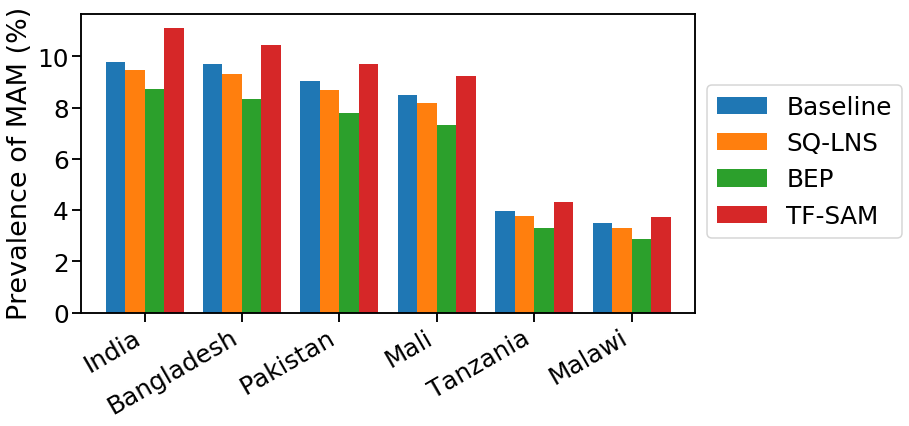

In [25]:
def my_plot(cols_to_blank=[]):
    t = results.loc[location_list, ('mean', 'pct')].astype(float)\
        .filter(['baseline', 'sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['Baseline', 'SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('Baseline', ascending=False)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('Prevalence of MAM (%)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

# Plot delta MAM by location and scenario

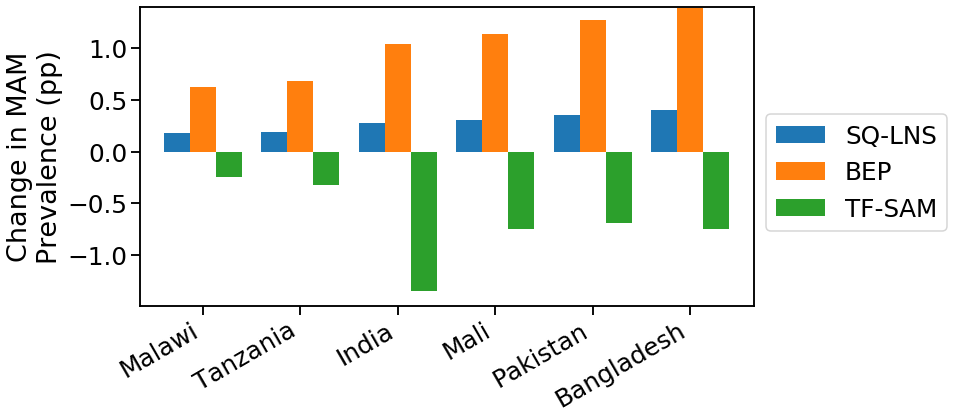

In [26]:
def my_plot(cols_to_blank=[]):
    t = results.loc[location_list, ('mean', 'delta_abs')].astype(float)\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
    plt.axis(ymax=1.4)
    plt.ylabel('Change in MAM\nPrevalence (pp)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

# Plot relative delta MAM by location and scenario

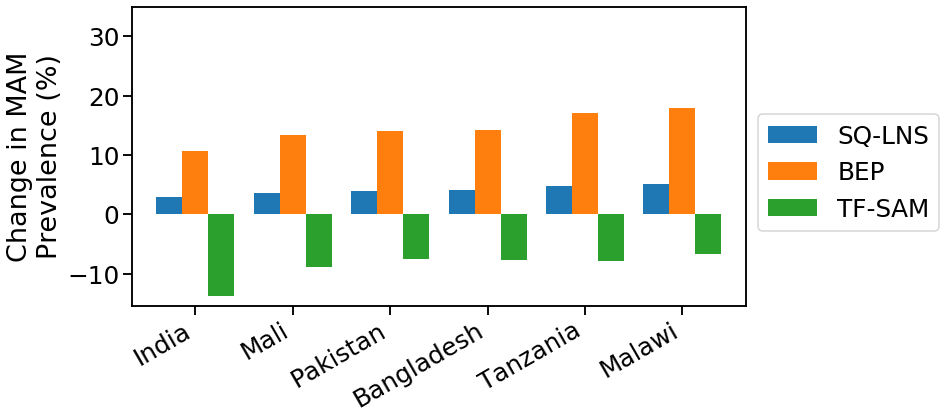

In [27]:
def my_plot(cols_to_blank=[]):
    t = results.loc[location_list, ('mean', 'delta_rel')].astype(float)\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
    plt.axis(ymax=35)
    plt.ylabel('Change in MAM\nPrevalence (%)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])